# IMPORTS

## Instalations

In [2]:
%pip install inflection
%pip install seaborn
%pip install tabulate
%pip install sklearn
%pip install boruta
%pip install xgboost

     |████████████████████████████████| 61kB 3.3MB/s 


## Libraries

In [3]:
from google.colab import drive

import math
import datetime
import random
import warnings
from IPython.core.display import HTML
from IPython.display import Image

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import gridspec

import pickle
from tabulate import tabulate
from scipy import stats as ss
import inflection
import xgboost as xgb

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

from boruta import BorutaPy

warnings.filterwarnings('ignore')

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# 0.1. Helper Functions

In [129]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [130]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [5]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
  mae_list = []
  mape_list = []
  rmse_list = []
  for k in reversed(range(1, kfold+1)):
    if verbose:
        print('\nKFold Number: {}'.format(k))

    #start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    # training and validation dataset
    #validation
    xtraining = training.drop(['date', 'sales'], axis=1)
    ytraining = training['sales']

    #validation
    xvalidation = validation.drop(['date', 'sales'], axis=1)
    yvalidation = validation['sales']

    # model
    m = model.fit(xtraining, ytraining)

    # prediction
    yhat = m.predict(xvalidation)

    # performance
    m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

    # store performance of each kfold iteration
    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])
    
  return pd.DataFrame({'Model Name': model_name,
          'MAE CV':str(np.round(np.mean(mae_list), 2)) + ' +/- ' + str(np.round(np.std(mae_list), 2)),
          'MAPE CV':str(np.round(np.mean(mape_list), 2)) + ' +/- ' + str(np.round(np.std(mape_list), 2)),
          'RMSE CV':str(np.round(np.mean(rmse_list), 2)) + ' +/- ' + str(np.round(np.std(rmse_list), 2))}, index=[0])

In [6]:
def cramer_v(x, y): 
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

In [7]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# 0.2. Loading data

## 0.2.1. Initial Data

In [8]:
df_sales_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 0.2.2.Fast Data

In [9]:
model_xgb_tuned = pickle.load(open('/content/drive/My Drive/Colab Notebooks/results/model_xgb_tuned.pkl', 'rb'))
yhat_xgb_tuned = pickle.load(open('/content/drive/My Drive/Colab Notebooks/results/yhat_xgb_tuned.pkl', 'rb'))
xgb_result_tuned = pickle.load(open('/content/drive/My Drive/Colab Notebooks/results/xgb_result_tuned.pkl', 'rb'))

In [10]:
# tabela com regressões depois do Cross Validation

modelling_result_cv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/results/general_cv.csv")

In [11]:
# Linear Regression Cross Validation

lr_result_cv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/results/lr_cv')

In [12]:
lrr_result_cv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/results/lrr_cv')

In [13]:
# Random Forest Cross Validation

rf_result_cv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/results/rf_cv.csv')

In [14]:
# XGBoost Cross Validation

model_xgb_result_cv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/results/xgb_cv.csv')

# 1.0. DESCRICAO DOS DADOS

## 1.1. Rename Columns

In [16]:
df1 = df_raw.copy()

In [17]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [18]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [19]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [20]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [21]:
df1['competition_distance'].max()

75860.0

In [22]:
#competition_distance  
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 
                                  if math.isnan(x) else x)

#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)


#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                               else x['competition_open_since_year'], axis=1)

                              
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis=1)

#promo2_since_year   
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [23]:
df1.sample(5).T

,870632,442536,266209,41040,431216
store,603,667,1008,901,497
day_of_week,7,6,7,4,2
date,2013-05-12 00:00:00,2014-05-31 00:00:00,2014-11-30 00:00:00,2015-06-25 00:00:00,2014-06-10 00:00:00
sales,0,7628,0,5732,9575
customers,0,756,0,547,1258
open,0,1,0,1,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,a,a


In [24]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

# 1.6. Change Types

In [25]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [26]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [27]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# 1.7. Descriptive Statistical

In [28]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [29]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [30]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                                       
# concatenate
                                       
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


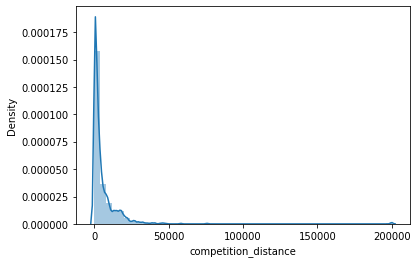

In [31]:
sns.distplot(df1['competition_distance'])

# 1.7.2 Categorical Attributes

In [32]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

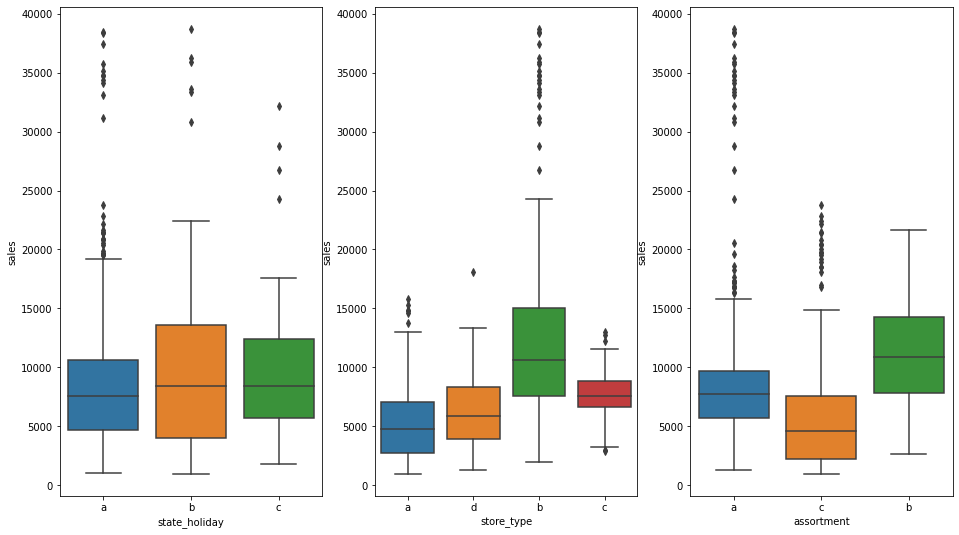

In [33]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(16, 9))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. Passo 02 - Feature Engineering

In [34]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

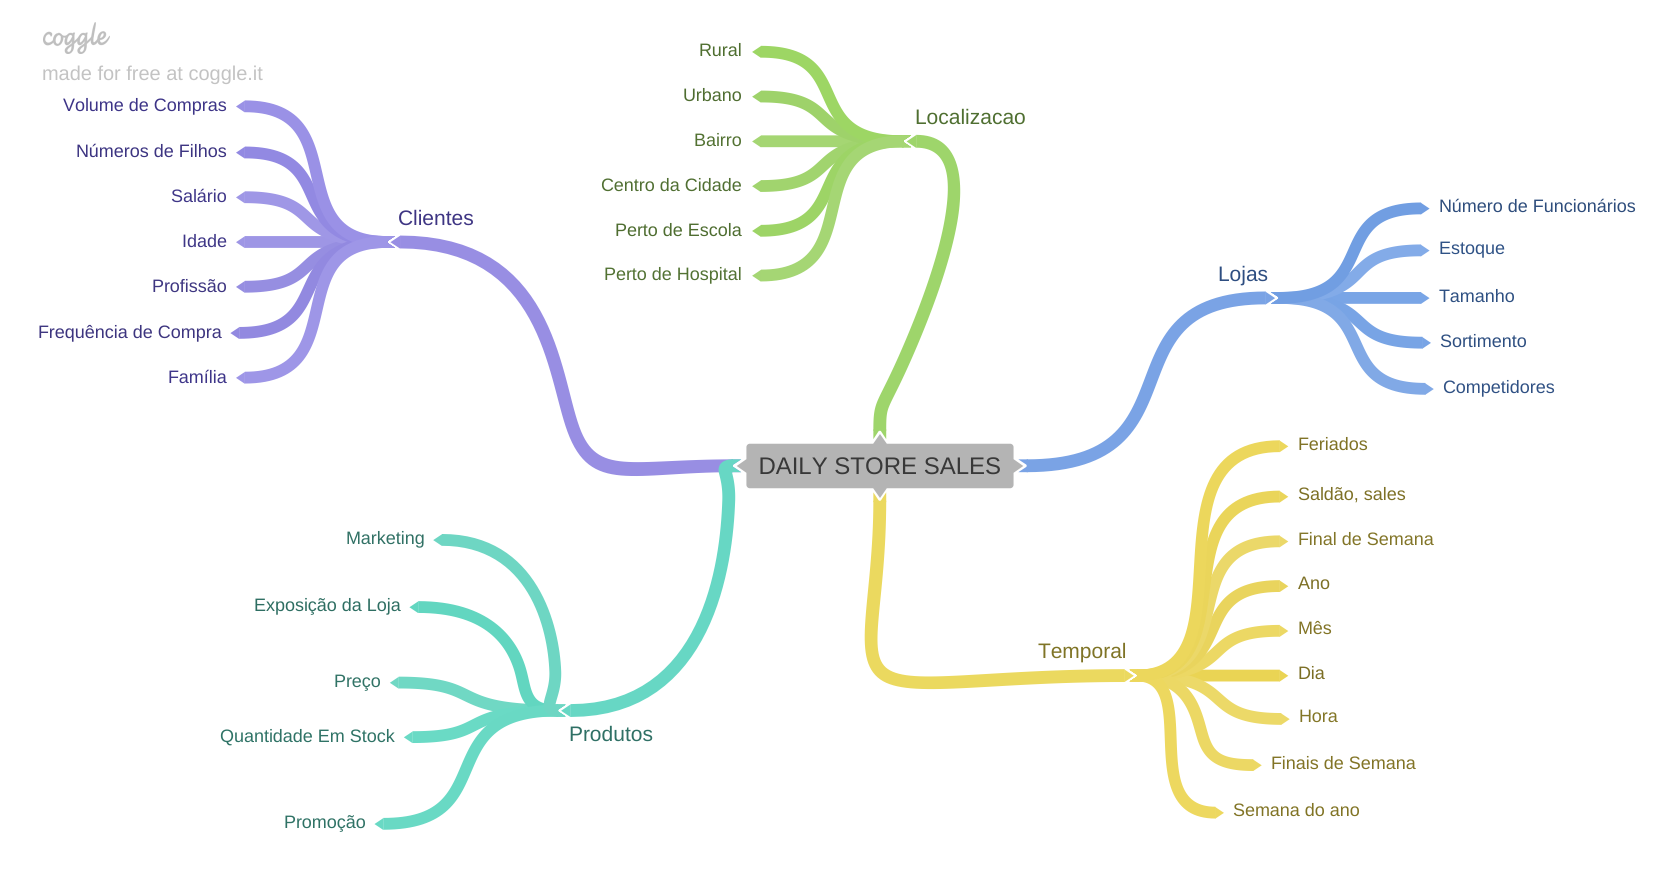

In [35]:
Image('/content/drive/My Drive/Colab Notebooks/data/mindmap.png')

## 2.1. Criação das Hipoteses

### 2.1.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.1.4. Lista Final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [36]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [37]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [38]:
df3 = df2.copy()

In [39]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [40]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [41]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [42]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [43]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

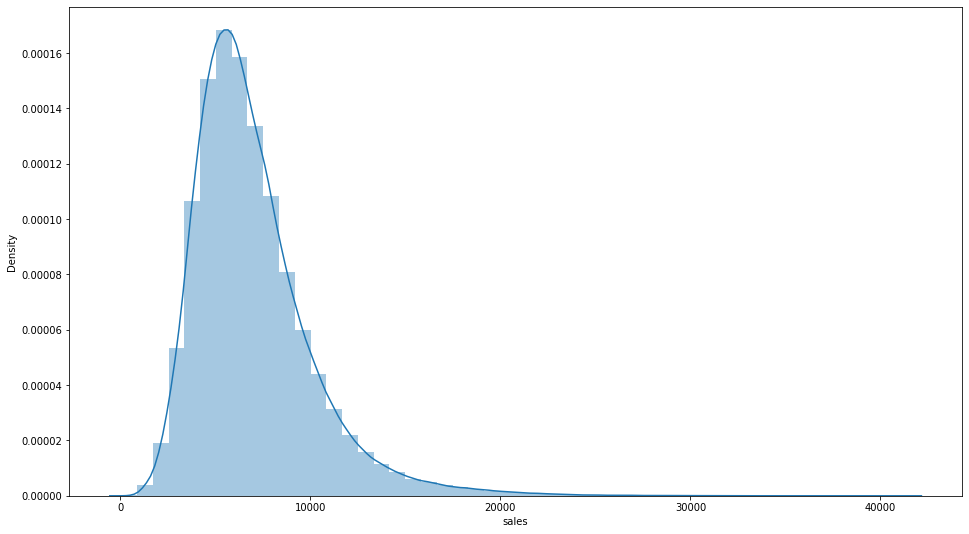

In [44]:
plt.figure(figsize=(16, 9))
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

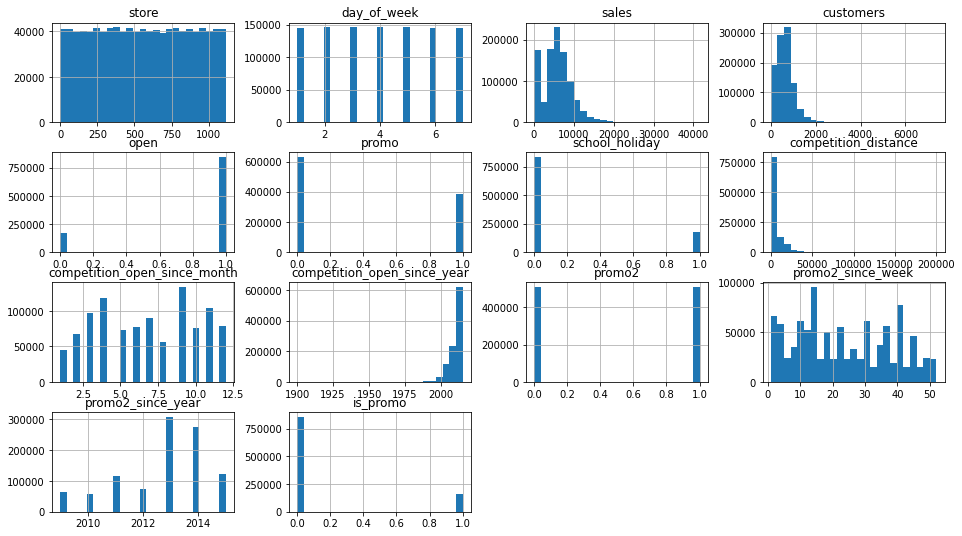

In [45]:
num_attributes.hist(figsize=(16,9), bins=25);

### 4.1.3. Categorical Variable

In [46]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

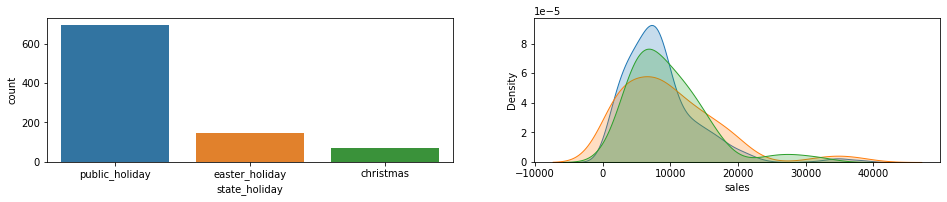

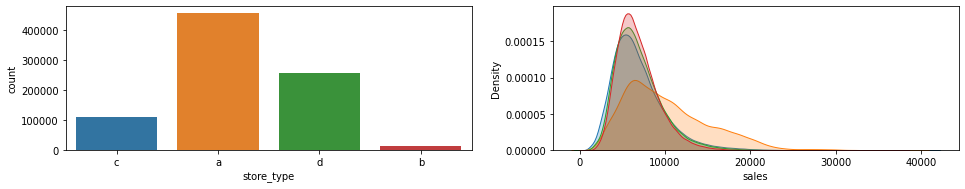

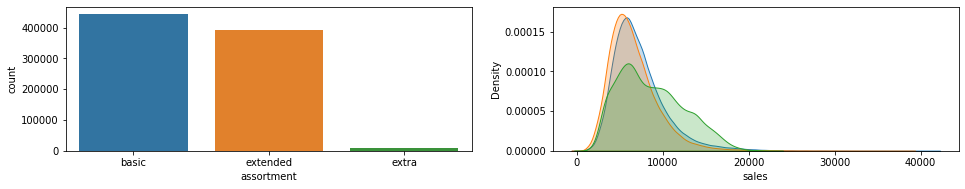

In [47]:
#state_holiday

#fig = plt.figure(figsize=(14,7))
#specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
#ax1 = fig.add_subplot(specs[0, 0])
#ax2 = fig.add_subplot(specs[0,1])

figura = plt.figure(figsize=(16,9))
figura.add_subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

figura.add_subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
figura = plt.figure(figsize=(16,9))
figura.add_subplot(3, 2, 3)
sns.countplot(df4['store_type'])

figura.add_subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
figura = plt.figure(figsize=(16,9))
figura.add_subplot(3, 2, 5)
sns.countplot(df4['assortment'])

figura.add_subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**VERDADEIRO** Lojas com maior sortimento vendem mais

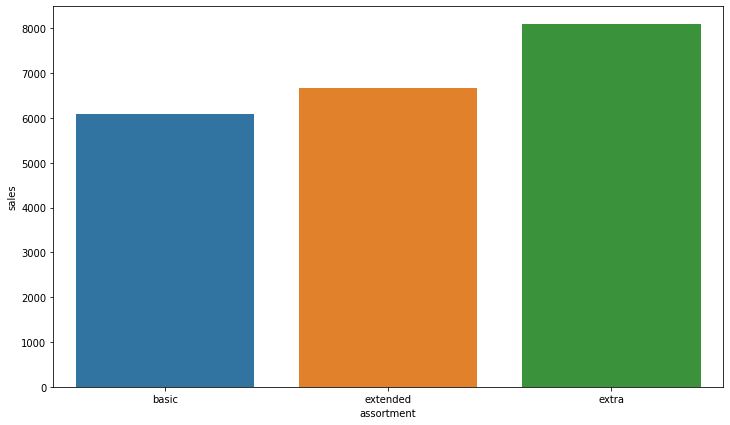

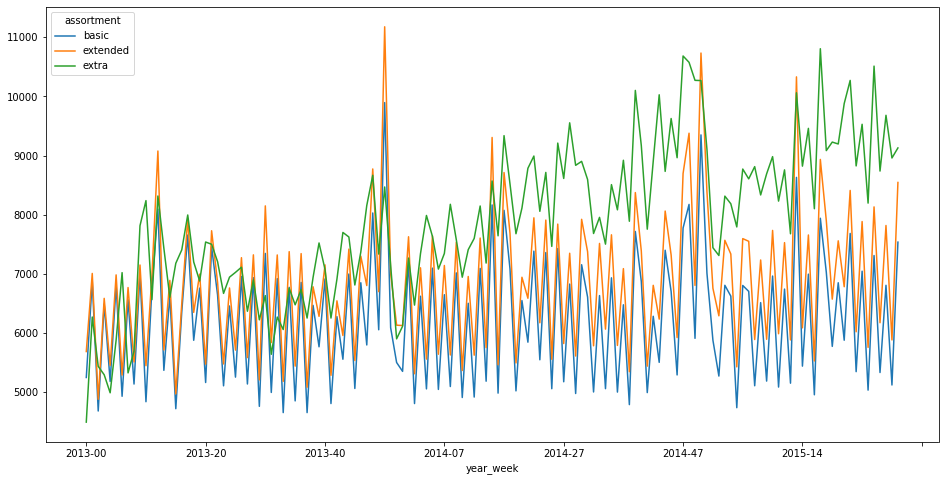

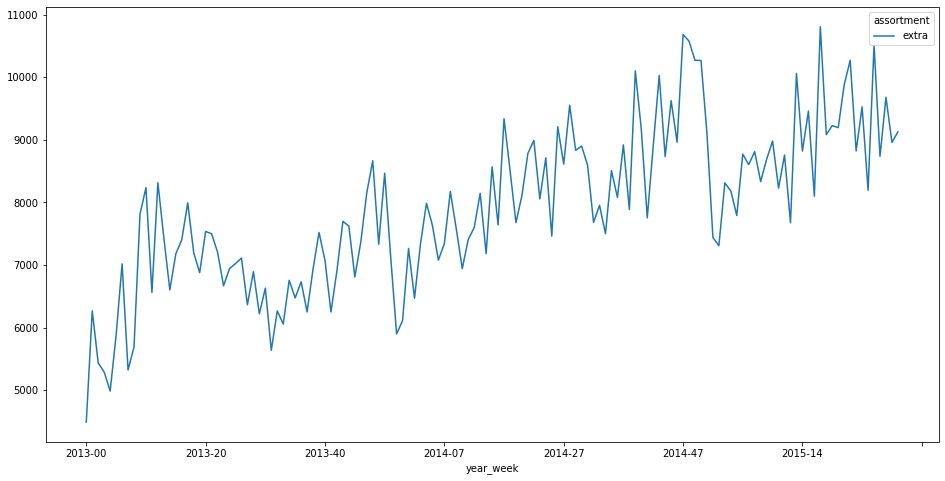

In [48]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').median().reset_index()
plt.figure(figsize=(12,7))
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).median().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(16,8))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(16,8))

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores mais próximos, vendem aproximadamente o mesmo.

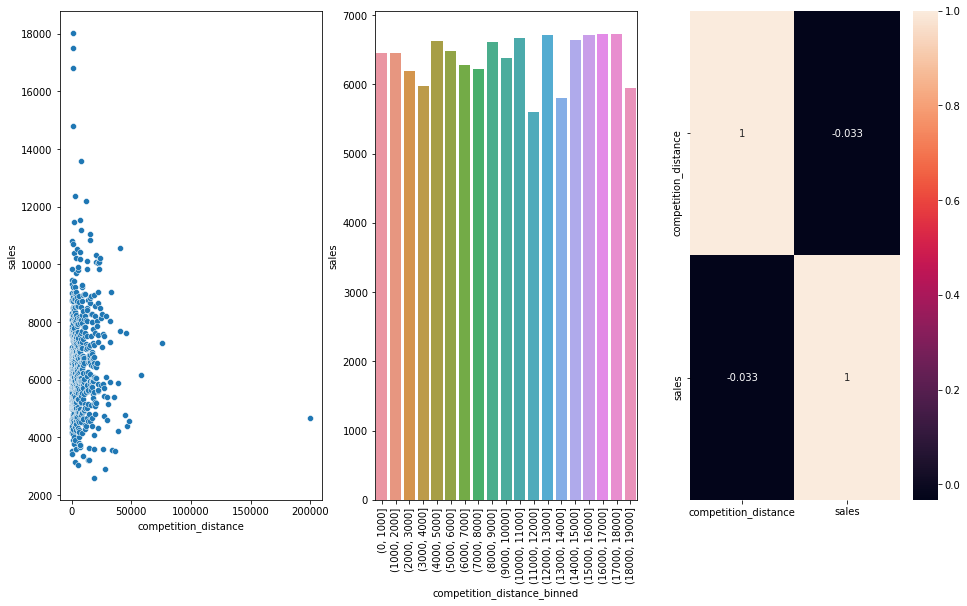

In [49]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()
figura = plt.figure(figsize=(16,9))

figura.add_subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

figura.add_subplot(1, 3, 2)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').median().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

figura.add_subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas com competidores a mais tempo vendem MENOS.

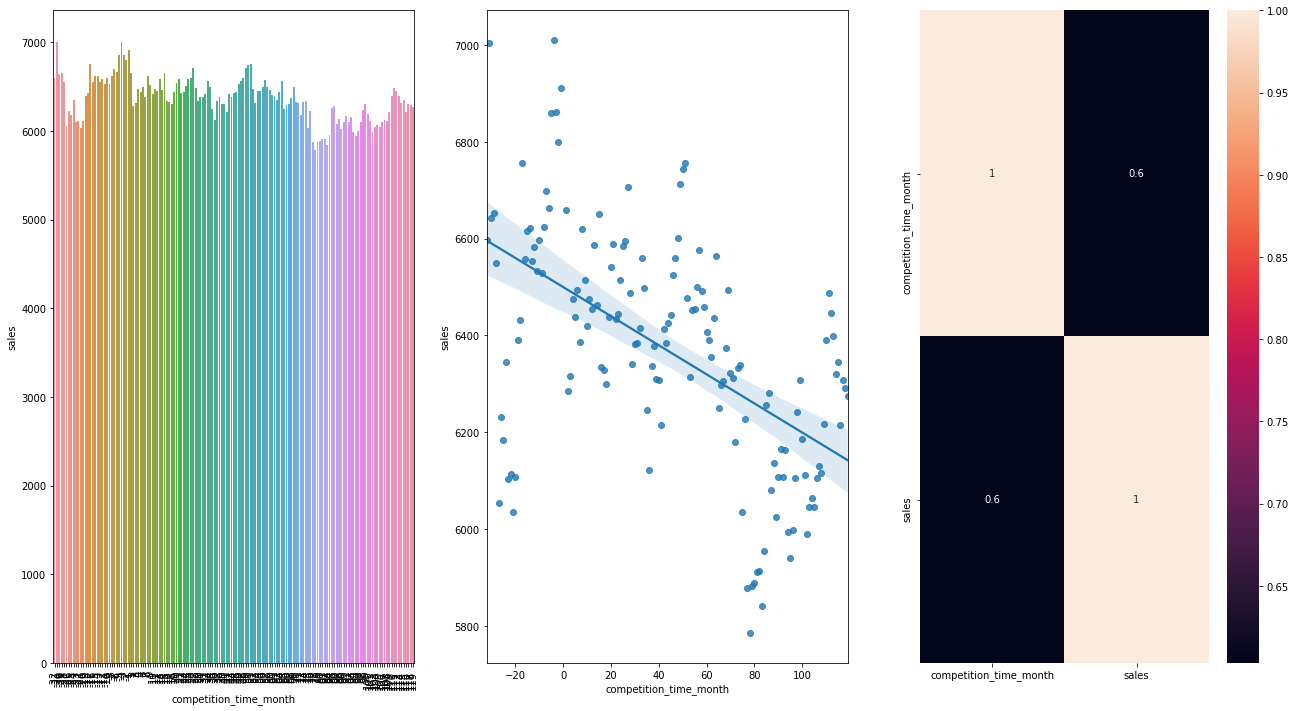

In [50]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').median().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

figura = plt.figure(figsize=(22,12))
figura.add_subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

figura.add_subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

figura.add_subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**VERDADEIRO** Pois promoções ativas por mais tempo vendem mais.

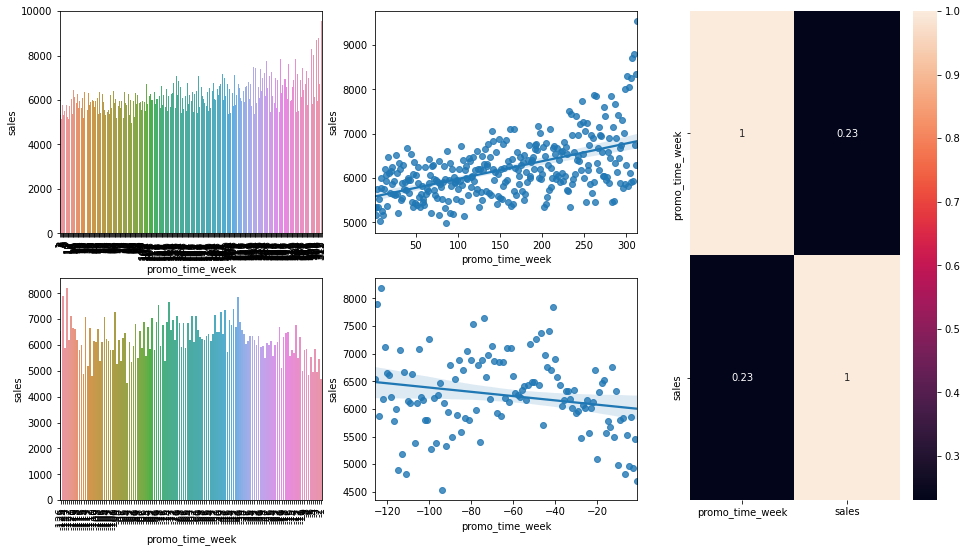

In [51]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').median().reset_index()

grid = gridspec.GridSpec(2, 3)

figura = plt.figure(figsize=(16,9))
#figura.add_subplot(2, 1, 1)
#sns.barplot(x='promo_time_week', y='sales', data=aux1);

figura.add_subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

figura.add_subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

figura.add_subplot(grid[1,0])
aux3 = aux1[(aux1['promo_time_week'] < 0)] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

figura.add_subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

figura.add_subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos

In [52]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).median().reset_index()

,promo,promo2,sales
0,0,0,5757
1,0,1,5181
2,1,0,7950
3,1,1,7358


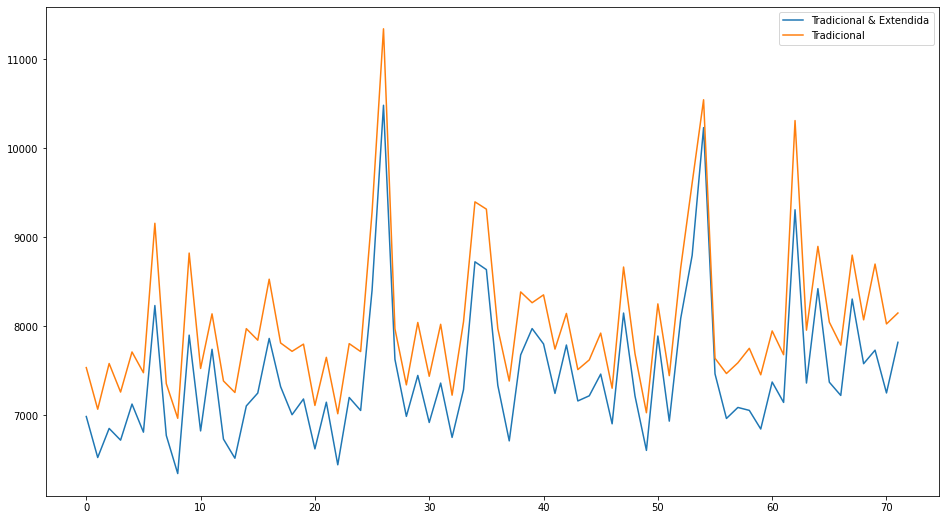

In [53]:
#figura = plt.figure(figsize=(16,9))
#figura.add_subplot(1, 1, 1)

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').median().reset_index()

ax = aux1.plot(figsize=(16,9));


aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').median().reset_index()
aux2.plot(figsize=(16,9), ax=ax);

ax.legend(labels=['Tradicional & Extendida', 'Tradicional']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de páscoa vendem mais do que o feriado do natal.

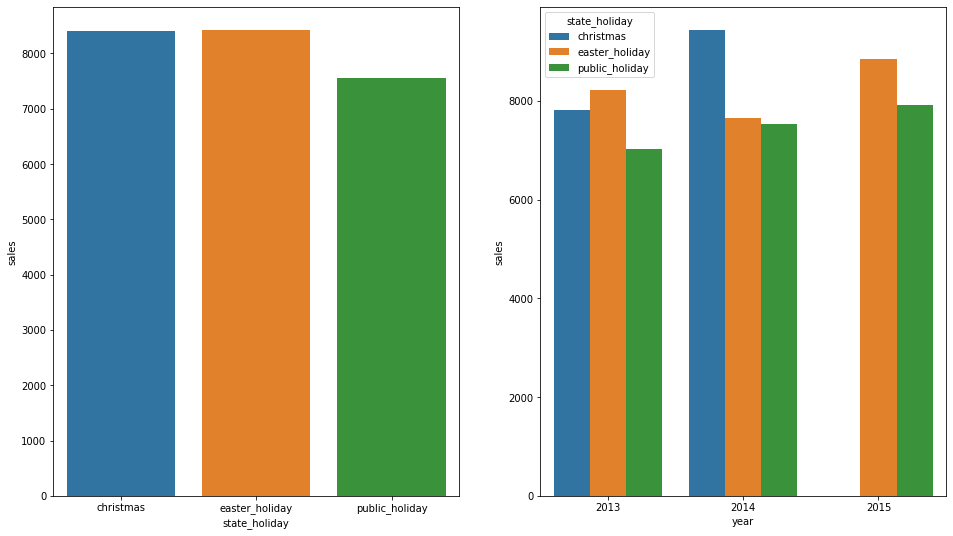

In [54]:
figura = plt.figure(figsize=(16,9))

aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').median().reset_index()

figura.add_subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data=aux1);

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).median().reset_index()

figura.add_subplot(1, 2, 2)
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Verdadeiro** Lojas vendem mais ao longo dos anos.

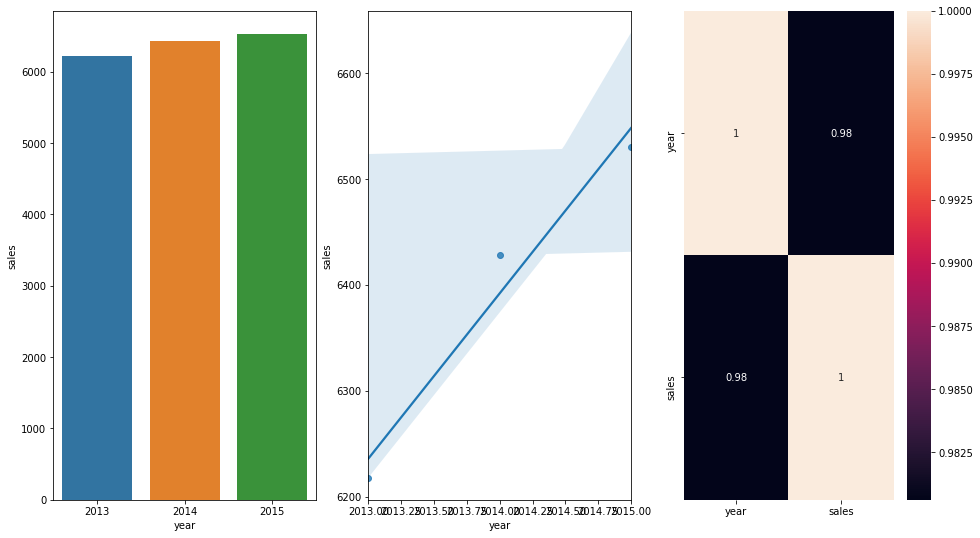

In [55]:
figura = plt.figure(figsize=(16,9))

aux1 = df4[['year', 'sales']].groupby('year').median().reset_index()

figura.add_subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

figura.add_subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

figura.add_subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRA** Lojas vendem mais durante o segundo menestre do ano.

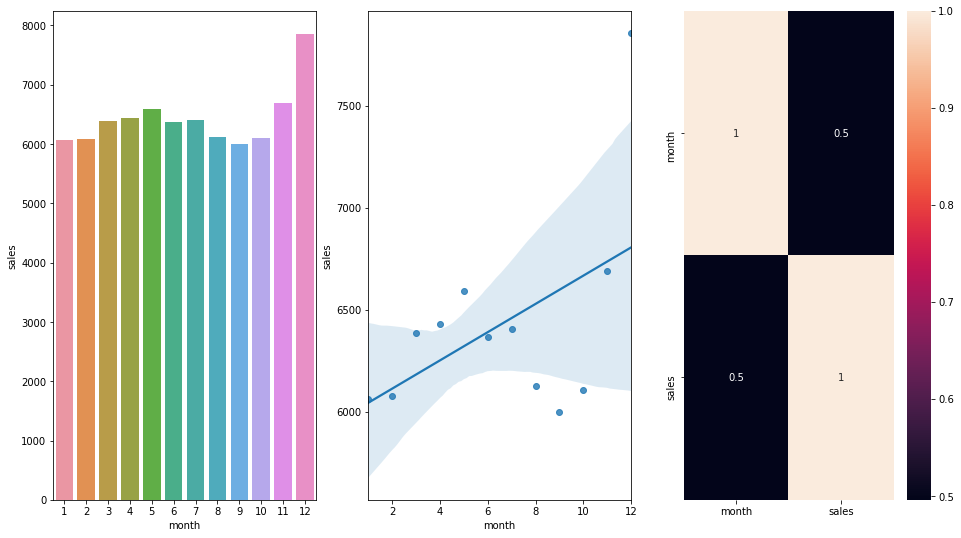

In [56]:
figura = plt.figure(figsize=(16,9))

aux1 = df4[['month', 'sales']].groupby('month').median().reset_index()

figura.add_subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

figura.add_subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

figura.add_subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**FALSA** Lojas vendem menos depois do dia 10 de cada mês.

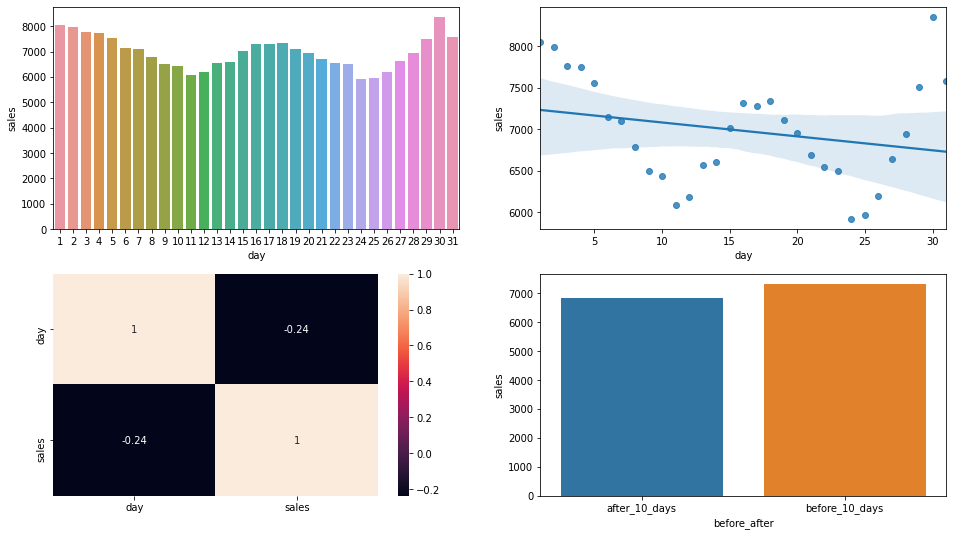

In [57]:
figura = plt.figure(figsize=(16,9))

aux1 = df4[['day', 'sales']].groupby('day').mean().reset_index()

figura.add_subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

figura.add_subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

figura.add_subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').mean().reset_index()

figura.add_subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**FALSA** Lojas vendem mais no final de semana.

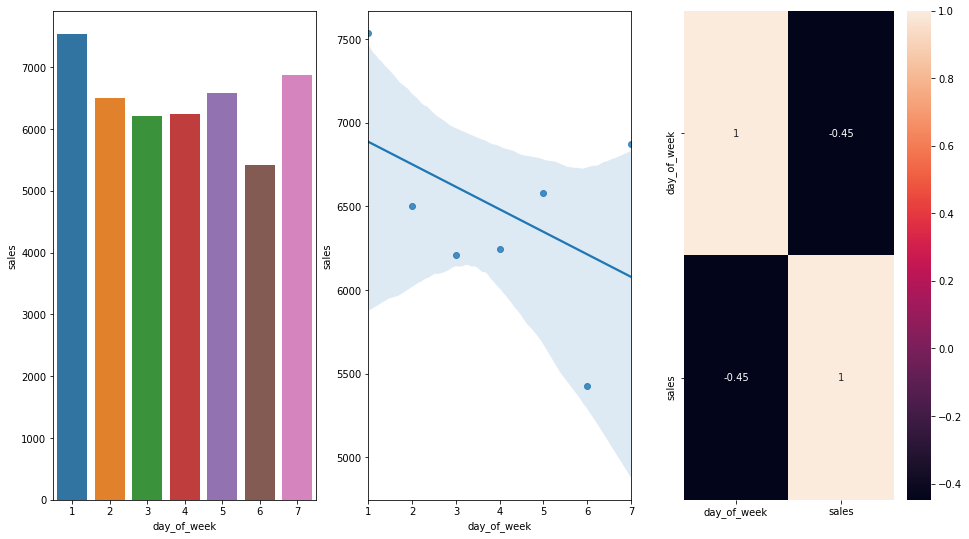

In [58]:
figura = plt.figure(figsize=(16,9))

aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').median().reset_index()

figura.add_subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

figura.add_subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

figura.add_subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas abertas durante os feriados escolares, vendem mais.

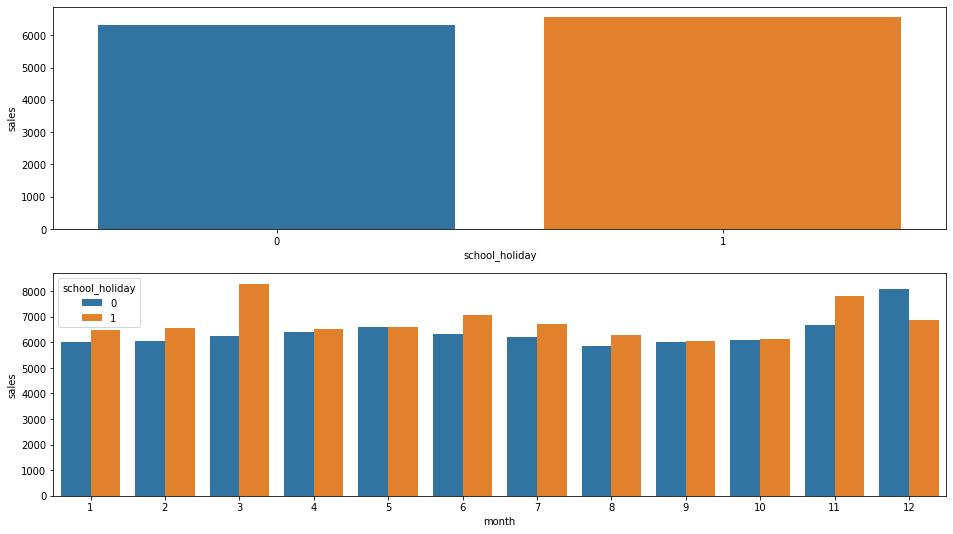

In [59]:
figura = plt.figure(figsize=(16,9))

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').median().reset_index()

figura.add_subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).median().reset_index()

figura.add_subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Resumo das Hipoteses

In [60]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'],
       ['H1', 'Verdadeira', 'Alta'],
       ['H2', 'Falsa', 'Baixa'],
       ['H3', 'Falsa', 'Alta'],
       ['H4', 'Verdadeira', 'Média'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Média'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Verdadeira', 'Alta'],
       ['H9', 'Verdadeira', 'Alta'],
       ['H10', 'Falsa', 'Média'],
       ['H11', 'Falsa', 'Média'],
       ['H12', 'Verdadeira', 'Baixa']]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Verdadeira   Alta
H2           Falsa        Baixa
H3           Falsa        Alta
H4           Verdadeira   Média
H5           -            -
H6           Falsa        Média
H7           Falsa        Baixa
H8           Verdadeira   Alta
H9           Verdadeira   Alta
H10          Falsa        Média
H11          Falsa        Média
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

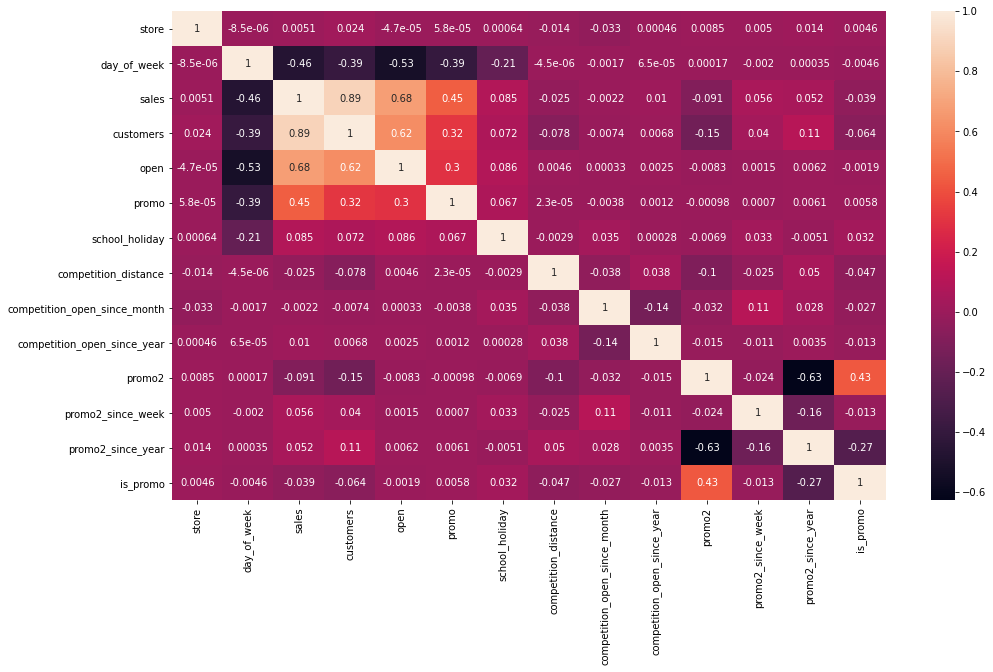

In [61]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(16,9))
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

In [62]:
a = df4.select_dtypes(include='object')

In [63]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday':[a1, a2, a3], 
                  'store_type':[a4, a5, a6],
                  'assortment':[a7, a8, a9]})

d = d.set_index(d.columns)

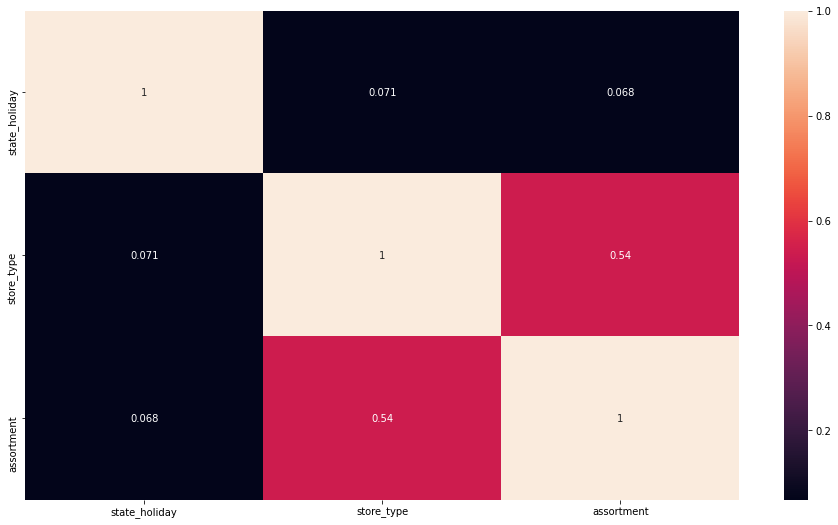

In [64]:
plt.figure(figsize=(16,9))
sns.heatmap(d, annot=True);

# 5.0. PASSO 05 - DATA PREPARATION

In [65]:
df5 = df4.copy()

## 5.1. Normalização (Sem Variáveis)

## 5.2. Rescaling

In [66]:
a = df5.select_dtypes(include=['int64', 'float64'])

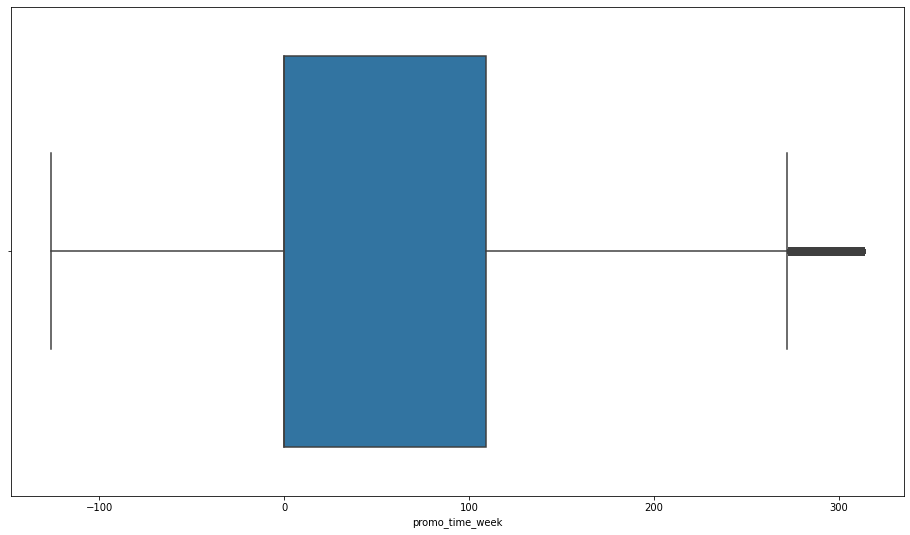

In [67]:
plt.figure(figsize=(16, 9))
sns.boxplot(df5['promo_time_week']);

In [68]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )                              

# year
df5['year'] = mms.fit_transform( df5[['year']].values )                              

## 5.3. Transformation

### 5.3.1. Encoding

In [69]:
# state_holiday = One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [70]:
# store_type = Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

In [71]:
# assortment = Ordinal Encoding

assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [72]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [73]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

In [74]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 06 - FEATURE SELECTION

In [75]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [76]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [77]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [78]:
# training dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTesting Min Date: {}'.format(X_test['date'].min()))
print('Testing Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Testing Min Date: 2015-06-19 00:00:00
Testing Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [79]:
# training and testing dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [80]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


### 6.2.1. Best Features from Boruta

In [81]:
# rodado no Google Colab

#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [82]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment',
                       'competition_distance', 'competition_open_since_month',
                       'competition_open_since_year', 'promo2', 'promo2_since_week',
                       'promo2_since_year', 'competition_time_month', 'promo_time_week',
                       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin',
                       'day_cos', 'week_of_year_sin', 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [83]:
cols_not_selected_boruta = ['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

# 7.0. PASSO 07 - Machine Learning Modelling

In [84]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1. Average Model

In [85]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').median().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1335.706252,0.448645,1872.027111


## 7.2. Linear Regression Model

In [86]:
# model
#lr = LinearRegression().fit(x_train, y_train)

# prediction
#yhat_lr = lr.predict(x_test)

# performance
#lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
#lr_result

### 7.2.1. Linear Regression Model - Cross Validation

In [87]:
#lr = LinearRegression()
#lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Unnamed: 0,Model Name,MAE CV,MAPE CV,RMSE CV
0,0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [88]:
# model
#lrr = Lasso(alpha=0.001).fit(x_train, y_train)

# prediction
#yhat_lrr = lrr.predict(x_test)

# performance
#lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
#lrr_result

### 7.3.1. Linear Regression Regularized Model (Lasso) - Cross Validation
---



In [89]:
#lrr = Lasso(alpha=0.01)
#lrr_result_cv = cross_validation(x_training, 5, 'Linear Regularized Regression Model (Lasso)', lrr, verbose=False)
lrr_result_cv

,Unnamed: 0,Model Name,MAE CV,MAPE CV,RMSE CV
0,0,Linear Regularized Regression Model (Lasso),2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [90]:
# model
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit( x_train, y_train )

# prediction
#yhat_rf = rf.predict(x_test)

# performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

### 7.4.1. Random Forest Regressor - Cross Validation

In [91]:
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

,Unnamed: 0,Model Name,MAE CV,MAPE CV,RMSE CV
0,0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67


## 7.5. XGBoost Regressor

In [92]:
# model
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators= 100, eta=0.01, 
#                             max_depth=10, subsample=0.7, colsample_bytee=0.9).fit( x_train, y_train )

# prediction
#yhat_xgb = model_xgb.predict(x_test)

# performance
#xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
#xgb_result

### 7.6.1. XGBoost Regressor - Cross Validation 

In [93]:
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators= 100, eta=0.01, 
#                             max_depth=10, subsample=0.7, colsample_bytee=0.9)
#model_xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
model_xgb_result_cv

,Unnamed: 0,Model Name,MAE CV,MAPE CV,RMSE CV
0,0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6. Compare Model's Performance

In [94]:
#modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modelling_result.sort_values('RMSE')

In [95]:
x_training = X_train[cols_selected_boruta_full]

In [96]:
#model = LinearRegression()
#a = cross_validation(x_training, 5, 'Linear Regression', model, verbose=True)

### 7.7.1. Real Performance - Cross Validation

In [97]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, model_xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Unnamed: 0,Model Name,MAE CV,MAPE CV,RMSE CV
0,0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67
0,0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79
0,0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,0,Linear Regularized Regression Model (Lasso),2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [98]:
#param = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
#         'eta':[0.01, 0.03],
#         'max_depth':[3, 5, 9],
#         'subsample':[0.1, 0.5, 0.7],
#         'colsample_bytee':[0.3, 0.7, 0.9],
#         'min_child_weight':[3, 8, 15]}

#MAX_EVAL = 2

In [99]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
  # choose values for parameters randomly
#  hp = {k:random.sample(v, 1)[0] for k, v in param.items()}
#  print(hp)

  # model
#  model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators= hp['n_estimators'], eta=hp['eta'], 
#                              max_depth=hp['max_depth'], subsample=hp['subsample'], colsample_bytee=hp['colsample_bytee'],
#                              min_child_weight=hp['min_child_weight'])

  # performance
#  result = cross_validation(x_training, 3, 'XGBoost Regressor', model_xgb, verbose=False)
#  final_result = pd.concat([final_result, result])

#print(final_result)
#final_result.to_csv('/content/drive/My Drive/Colab Notebooks/results/final_result_xgb_cv.csv')

## 8.2. Final Model Search

In [100]:
param_tuned = {'n_estimators': 3000,
         'eta': 0.03,
         'max_depth': 5,
         'subsample': 0.7,
         'colsample_bytee': 0.7,
         'min_child_weight': 3}

In [101]:
# model
#model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', n_estimators= param_tuned['n_estimators'], eta=param_tuned['eta'], 
#                               max_depth=param_tuned['max_depth'], subsample=param_tuned['subsample'], colsample_bytee=param_tuned['colsample_bytee'],
#                               min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
#yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
#xgb_result_tuned = ml_error('XGBoost Regressor Tuned', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Unnamed: 0,Model Name,MAE,MAPE,RMSE
0,0,XGBoost Regressor Tuned,664.974997,0.097529,957.774225


In [102]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

# 9.0. PASSO 09 - Tradução e Interpretação do Erro

In [106]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [152]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - (df92['MAPE']*df92['predictions'])
df92['best_scenario'] = df92['predictions'] + (df92['MAPE']*df92['predictions'])

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [153]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.085938,45168.242739,162897.929136,3318.104402,0.565828
908,909,238233.875000,114249.019227,362218.730773,7660.537746,0.520433
875,876,203030.156250,141085.778935,264974.533565,3919.203836,0.305099
721,722,353005.781250,258280.807271,447730.755229,1992.156131,0.268338
594,595,400883.625000,303792.971218,497974.278782,3468.361830,0.242192


In [155]:
df92['predictions'][291] - df92['worst_scenario'][291]

58864.84319803374

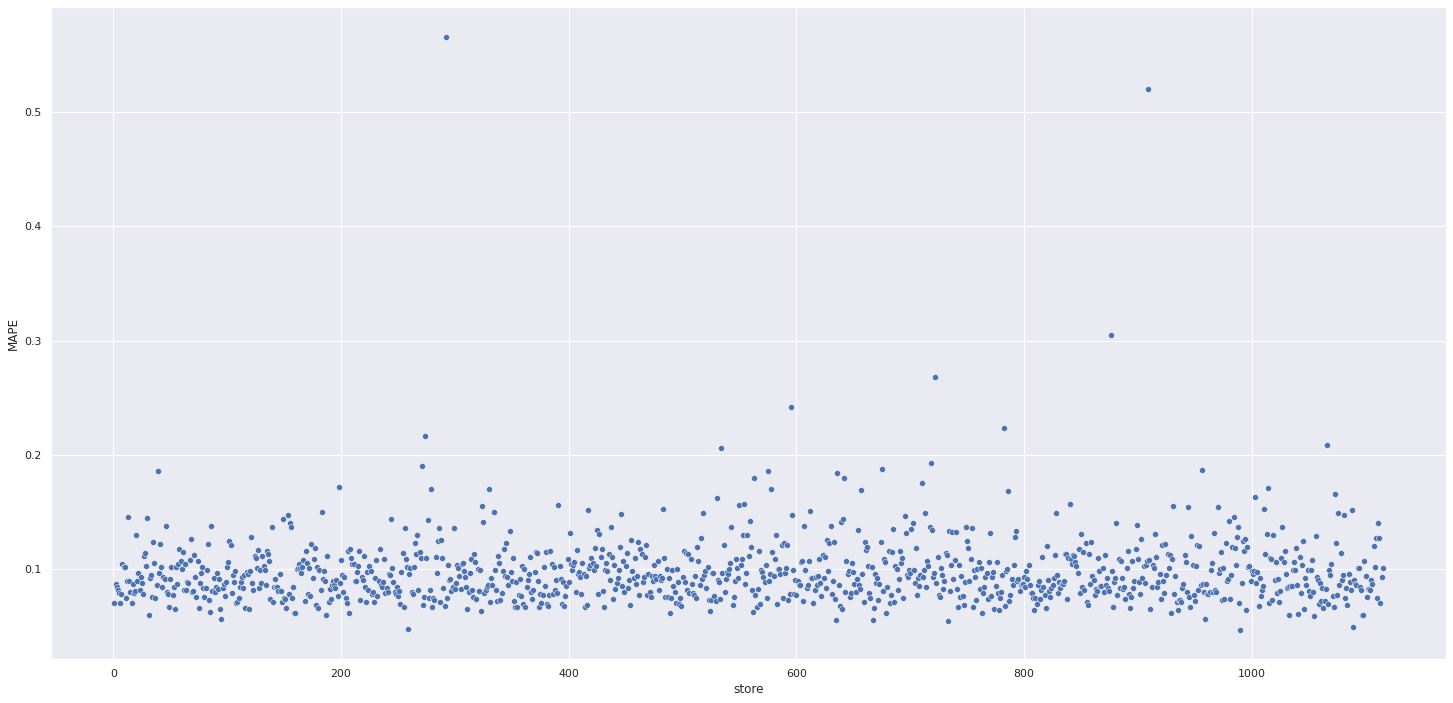

In [132]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [154]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$285,860,480.00"
1,worst_scenario,"R$258,289,614.55"
2,best_scenario,"R$313,431,381.14"


## 9.3. Machine Learning Performance

In [137]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

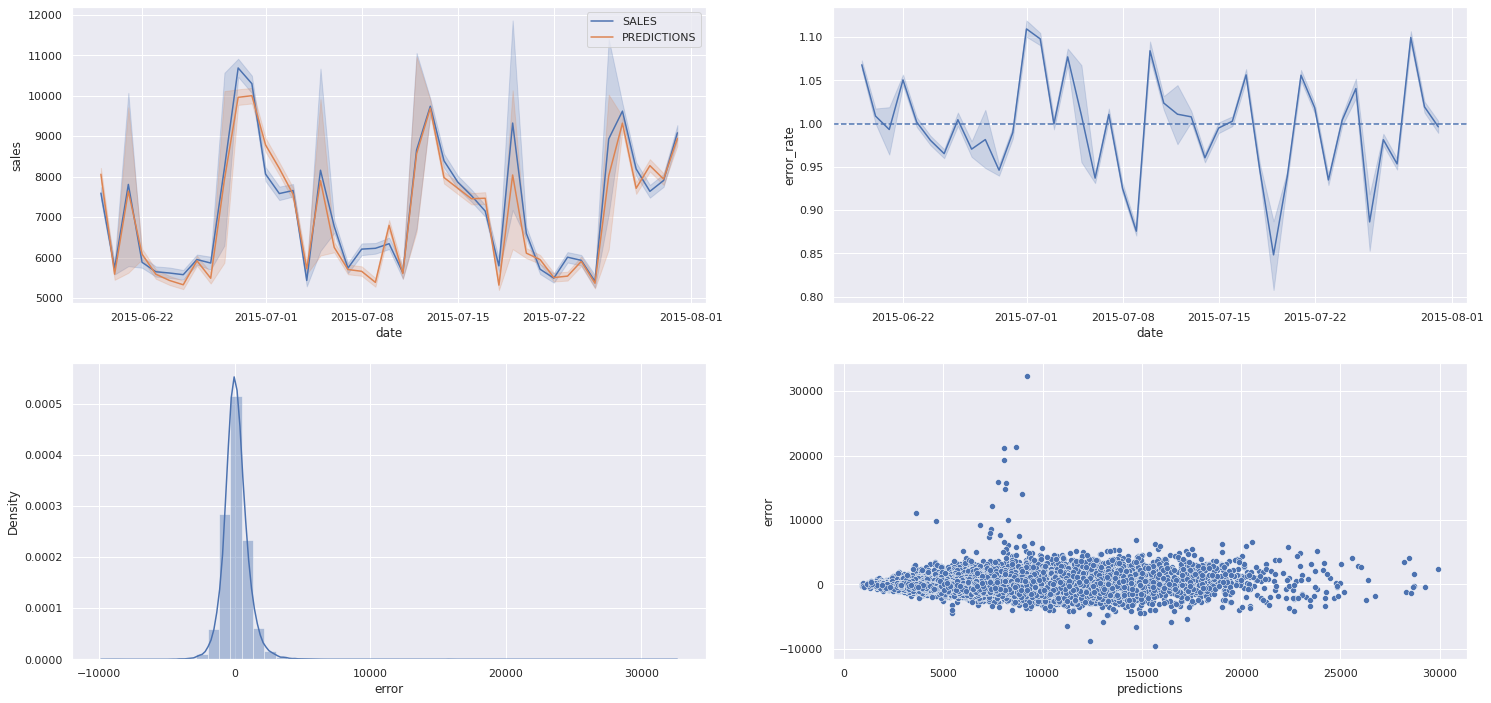

In [141]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline( 1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10. SAVING PICKLE FILES

In [103]:
#pickle.dump(model_xgb_tuned, open('/content/drive/My Drive/Colab Notebooks/results/model_xgb_tuned.pkl', 'wb'))
#pickle.dump(yhat_xgb_tuned, open('/content/drive/My Drive/Colab Notebooks/results/yhat_xgb_tuned.pkl', 'wb'))
#pickle.dump(xgb_result_tuned, open('/content/drive/My Drive/Colab Notebooks/results/xgb_result_tuned.pkl', 'wb'))

In [104]:
#model_xgb_tuned = pickle.load(open('/content/drive/My Drive/Colab Notebooks/results/model_xgb_tuned.pkl', 'rb'))
#yhat_xgb_tuned = pickle.load(open('/content/drive/My Drive/Colab Notebooks/results/yhat_xgb_tuned.pkl', 'rb'))
#xgb_result_tuned = pickle.load(open('/content/drive/My Drive/Colab Notebooks/results/xgb_result_tuned.pkl', 'rb'))